In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random
from patch_gnn.seqops import one_hot
from patch_gnn.unirep import unirep_reps
from patch_gnn.graph import graph_tensors
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
# taken from bench.ipynb
def plot_y_eq_x(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)

    ax.plot([minval, maxval], [minval, maxval])
def plot_performance(
    model,
    trainX, trainY, testX, testY,
    model_name: str,
    ev_func,
    checkpoint: int = None,
):
    fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )

    if isinstance(model, MPNN):
        train_preds = model.predict(trainX, checkpoint=checkpoint)
    else:
        train_preds = model.predict(trainX)
    ax[0].scatter(trainY, train_preds.squeeze())
    ax[0].set_title(f"Model: {model_name}, Training Perf: {ev_func(trainY, train_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[0])

    if isinstance(model, MPNN):
        test_preds = model.predict(testX, checkpoint=checkpoint)
    else:
        test_preds = model.predict(testX)
    ax[1].scatter(testY, test_preds.squeeze())
    ax[1].set_title(f"Model: {model_name}, Testing Perf: {ev_func(testY, test_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[1])

### LOAD train_df and test_df

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

In [5]:
key = random.PRNGKey(490)
filtered = (
    data
    .query("`accession-sequence` in @graphs.keys()")
    .query("ox_fwd_logit < 2.0")
    .join_apply(met_position, "met_position")
)
train_df, test_df = train_test_split(key, filtered) # 70% training, 30% testing

In [6]:
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

In [7]:
train_target.shape, test_target.shape

((258,), (111,))

### Load fluc features anm and nma 

In [8]:
with open(here() / "data/ghesquire_2011/ANM.pkl", "rb") as f:
    anm_dfs = pkl.load(f)
with open(here() / "data/ghesquire_2011/NMA.pkl", "rb") as f:
    nma_dfs = pkl.load(f)

In [9]:
def linear_model_data1(df, feature_dfs):
    """
    return a feature vector 
    :params df: either train_df or test_df
    :params feature_df: either anm_dfs or nma_dfs, they are dictionaries
                        with key being accesssion and values being features associated
                        that accession number
    """
    linear = []
    for acc, pos in zip(df["accession"], df["met_position"]):
        feature_dfs[acc] = feature_dfs[acc].replace(np.inf, 100000000)
        feats = feature_dfs[acc].query("resnos == @pos")[["fluc"]]
        linear.append(feats)

    return pd.concat(linear)


#### part I: try on AMN feature

In [10]:
train_linear_anm = linear_model_data1(train_df, anm_dfs)
test_linear_anm = linear_model_data1(test_df, anm_dfs)
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

##### fit a linear model

In [11]:
model_linear = LinearRegression()
model_linear.fit(train_linear_anm, train_target)

LinearRegression()

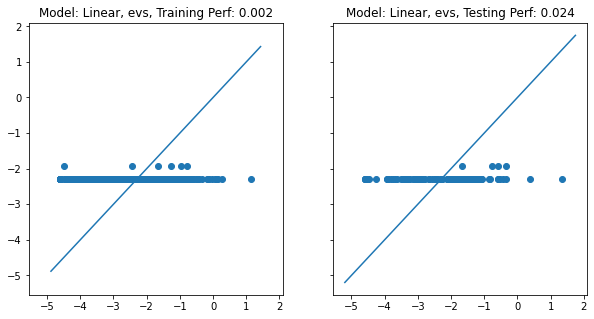

In [12]:
plot_performance(model_linear, train_linear_anm, train_target, test_linear_anm, test_target, 'Linear, evs', evs)

##### plot descriptor, target relation scatter plot

In [13]:
descriptor = pd.concat([train_linear_anm.reset_index(drop=True), test_linear_anm.reset_index(drop=True)], axis=0)
target = pd.concat([pd.Series(train_target), pd.Series(test_target)], axis=0)
train_test = pd.Series(["train"]*train_linear_anm.shape[0] + ['test']* test_linear_anm.shape[0])
scatter_df = pd.DataFrame({'fluc': descriptor['fluc'].tolist(), 'target': target.tolist(), 'train_test': train_test.tolist()})
scatter_df.shape

(369, 3)

Text(0.5, 1.0, 'ANM fluc vs. target in train and test set')

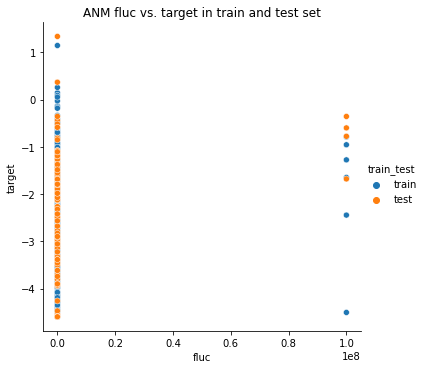

In [14]:
sns.relplot(x="fluc", y="target",hue="train_test", data=scatter_df)
plt.title('ANM fluc vs. target in train and test set')

##### drop inf in ANM and MNA for linear regression 

In [15]:
np.max(train_linear_anm)

fluc    100000000.0
dtype: float64

In [16]:
train_idx_to_drop_anm, _ = np.where(train_linear_anm ==100000000.0 )
test_idx_to_drop_anm, _ = np.where(test_linear_anm ==100000000.0 )
train_idx_to_drop_anm

array([ 56,  71,  90, 142, 190, 207])

In [17]:
# verify the max value is no longer 100000000 after drop
np.max(train_linear_anm.reset_index(drop=True).drop(train_idx_to_drop_anm))

fluc    1157.578347
dtype: float64

In [18]:
# verify selected rows
train_linear_anm.reset_index(drop=True).iloc[[ 56,  71,  90, 142, 190, 207],]

,fluc
56,100000000.0
71,100000000.0
90,100000000.0
142,100000000.0
190,100000000.0
207,100000000.0


In [19]:
train_linear_anm_drop_inf = train_linear_anm.reset_index(drop=True).drop(train_idx_to_drop_anm)
test_linear_anm_drop_inf = test_linear_anm.reset_index(drop=True).drop(test_idx_to_drop_anm)
train_target_anm_drop_inf = np.delete(train_target, train_idx_to_drop_anm)
test_target_anm_drop_inf = np.delete(test_target, test_idx_to_drop_anm)


Text(0.5, 1.0, 'ANM drop inf fluc vs. target drop inf in train and test set')

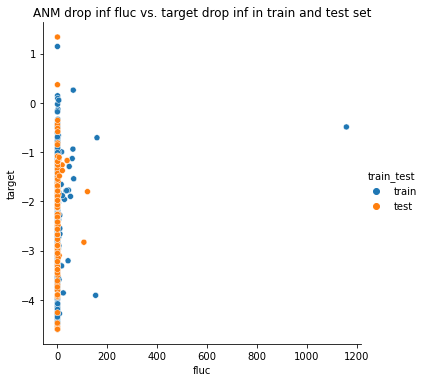

In [20]:
descriptor = pd.concat([train_linear_anm_drop_inf.reset_index(drop=True), test_linear_anm_drop_inf.reset_index(drop=True)], axis=0)
target = pd.concat([pd.Series(train_target_anm_drop_inf), pd.Series(test_target_anm_drop_inf)], axis=0)
train_test = pd.Series(["train"]*train_linear_anm_drop_inf.shape[0] + ['test']* test_linear_anm_drop_inf.shape[0])
scatter_df = pd.DataFrame({'fluc': descriptor['fluc'].tolist(), 'target': target.tolist(), 'train_test': train_test.tolist()})
scatter_df.shape
sns.relplot(x="fluc", y="target",hue="train_test", data=scatter_df)
plt.title('ANM drop inf fluc vs. target drop inf in train and test set')

#### no improvments after dropping inf on ANM

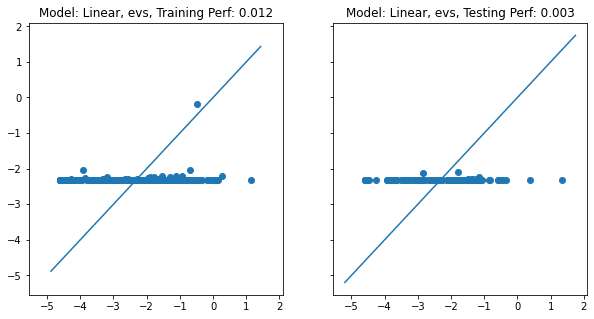

In [21]:
model_linear = LinearRegression()
model_linear.fit(train_linear_anm_drop_inf, train_target_anm_drop_inf)
plot_performance(model_linear, train_linear_anm_drop_inf, train_target_anm_drop_inf, test_linear_anm_drop_inf, test_target_anm_drop_inf, 'Linear, evs', evs)

### Conclusion
##### some structures are not complete, some proteins won't be typical globular proteins, the parameters don't reflect reliable fluc values. Even if we look at the distribution of the fluc, given the linear model is looking across proteins, the linear regression's parameter values might not be comparable. This descriptor might also not be available to other dataset. 

#### part II: try on NMA feature

##### convert inf to 100000000

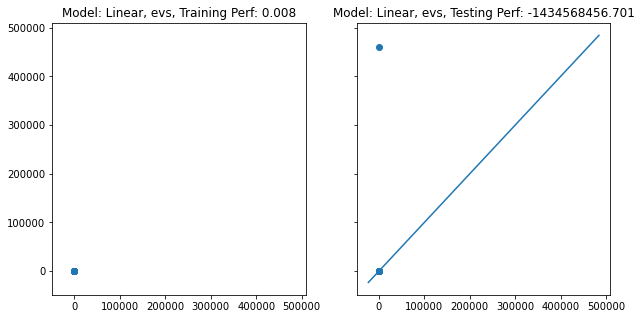

In [22]:
train_linear_nma = linear_model_data1(train_df, nma_dfs)
test_linear_nma = linear_model_data1(test_df, nma_dfs)
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

#fit linear model
model_linear = LinearRegression()
model_linear.fit(train_linear_nma, train_target)
plot_performance(model_linear, train_linear_nma, train_target, test_linear_nma, test_target, 'Linear, evs', evs)

##### drop inf, it seems there is only 1 sample with inf value, it is the 7th sample in test set, see below. Therefore, removing inf won't change the above plot much

In [23]:
train_idx_to_drop_nma, _ = np.where(train_linear_nma ==100000000.0 )
test_idx_to_drop_nma, _ = np.where(test_linear_nma ==100000000.0 )
train_idx_to_drop_nma, test_idx_to_drop_nma 

(array([], dtype=int64), array([7]))

In [24]:
#train_linear_nma_drop_inf = train_linear_nma.reset_index(drop=True).drop(train_idx_to_drop_nma)
test_linear_nma_drop_inf = test_linear_nma.reset_index(drop=True).drop(test_idx_to_drop_nma)
#train_target_nma_drop_inf = np.delete(train_target, train_idx_to_drop_nma)
test_target_nma_drop_inf = np.delete(test_target, test_idx_to_drop_nma)

###### plot NMA inf drop vs. target inf drop scatter plot

Text(0.5, 1.0, 'NMA inf drop vs. target inf drop in train and test set')

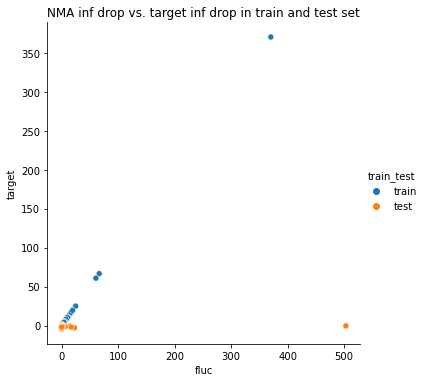

In [25]:
descriptor = pd.concat([train_linear_nma.reset_index(drop=True), test_linear_nma_drop_inf.reset_index(drop=True)], axis=0)
target = pd.concat([train_linear_nma.squeeze(), pd.Series(test_target_nma_drop_inf)], axis=0)
train_test = pd.Series(["train"]*train_linear_nma.shape[0] + ['test']* test_linear_nma_drop_inf.shape[0])
scatter_df = pd.DataFrame({'fluc': descriptor['fluc'].tolist(), 'target': target.tolist(), 'train_test': train_test.tolist()})
scatter_df.shape
sns.relplot(x="fluc", y="target",hue="train_test", data=scatter_df)
plt.title('NMA inf drop vs. target inf drop in train and test set')